In [63]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-01-29 06:32:24,527: Credentials are already in use. The existing account in the session will be replaced.


In [64]:
%%writefile train_power_classifier.py
import numpy as np
import pandas as pd
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.visualization import *
from qiskit_ibm_runtime.program import UserMessenger
from scipy.optimize import dual_annealing
import statistics


def main(backend, user_messenger, data, num_gate_layers, maxiter):
    results = {}
    training_result = dual_annealing(lambda param: loss_function(param, backend=backend, user_messenger=user_messenger, data=data), [(0, 1)] * num_gate_layers * 3, maxiter=maxiter)
    results[str(n) + ", " + str(i)] = {"num_params": num_gate_layers, "maxiter": maxiter, "training":training_result}
    return results

iteration_count = 0

def loss_function(parameters, backend=None, user_messenger=None, data=None):
    """

    :param parameters: A 1D array of parameters
    :param data: A Dataframe of training examples
    :return: Average classification error over all examples in the data.
    """
    
    np.random.shuffle(data)
    examples = data[:10]
    losses = []
    for ex in examples:
        losses.append(compute_single_loss(parameters, ex, backend))
    loss = statistics.mean(losses)
    global iteration_count
    iteration_count += 1
    return loss

def compute_single_loss(parameters, example, backend):
    """
    Example includes features and label. Returns classification error [0.0, 1.0]
    """
    qc = QuantumCircuit(3)
    embed_example(qc, example)
    apply_parameters(qc, parameters)
    result = run_circuit(qc, backend)
    return compute_loss(result, example)

def embed_example(circuit, example):
    circuit.rx(np.pi * example[0], 0)
    circuit.rx(np.pi * example[1], 1)
    circuit.rx(np.pi * example[2], 2)

def apply_parameters(circuit, parameters):
    # TODO: use full range
    layers = np.reshape(parameters, (int(len(parameters)/3), 3))
    layer_count = 1
    for layer in layers:
        for gate in range(len(layer)):
            if layer_count % 3 == 0:
                circuit.rx(np.pi * layer[gate], gate)
            elif layer_count % 3 == 1:
                circuit.ry(np.pi * layer[gate], gate)
            else:
                circuit.rz(np.pi * layer[gate], gate)
        circuit.cx(0,1)
        circuit.cx(1,2)
        circuit.cx(2,0)
        layer_count += 1
        circuit.barrier()
    circuit.measure_all()

def run_circuit(circuit, backend):

    num_shots = 1024
    job = execute(circuit,
                  shots=num_shots,
                  backend=backend)

    # Return the measured counts
    return job.result().get_counts()

def compute_loss(result, example):
    """
    Gives percentage of classification error based on quantum computer predictions
    """
    correct_count = 0
    # Majority vote, compute # of runs that vote for the right label across all measurements
    for measurement in result:
        # Determine vote
        vote = 0
        if measurement.count('1') > measurement.count('0'):
            vote = 1
        if vote == example[3]:
            correct_count += result[measurement]

    total_count = sum(result.values())
    return (total_count - correct_count) / total_count

Overwriting train_power_classifier.py


In [65]:
# from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService()
# meta = {
#     "name": "power-danger-binary",
#     "description": "Parameterized by num parameters and max iterations of dual annealing.",
#     "max_execution_time": 300000,
#     "spec": {},
# }
# program_id = service.upload_program(data="train_power_classifier.py", metadata=meta)
# print(program_id)

In [66]:
service = QiskitRuntimeService()
meta = {
    "name": "power-danger-binary",
    "description": "Parameterized by num parameters and max iterations of dual annealing.",
    "max_execution_time": 300000,
    "spec": {},
}
prog_id = 'power-danger-binary-56jewxa2XV'
service.update_program(prog_id, data="train_power_classifier.py", metadata=meta)
prog = service.program(prog_id)
print(prog)

power-danger-binary-56jewxa2XV:
  Name: power-danger-binary
  Description: Parameterized by num parameters and max iterations of dual annealing.
  Creation date: 2023-01-29T06:08:45.142275Z
  Update date: 2023-01-29T06:32:33.720382Z
  Max execution time: 300000
  Backend requirements:
    none
  Input parameters:
    none
  Interim results:
    none
  Returns:
    none


In [67]:
fake_train_data = np.random.randn(10,3)
print(fake_train_data)

fake_labels = np.array([np.random.randint(2, size=10)])
print(fake_labels)

np.concatenate((fake_train_data, fake_labels.T), axis=1)

[[ 0.57527275  0.08224729 -1.23076435]
 [-0.33391741 -0.45231781  0.18188075]
 [-0.13007259 -1.55370375 -0.28671736]
 [-0.01791477 -0.71276368 -0.05739586]
 [-2.3166851  -0.19425537  1.60066718]
 [ 1.30286007  0.04542252 -1.2460973 ]
 [ 0.76006083 -1.32699332  0.5612395 ]
 [-2.58308449 -0.32520964 -0.77430997]
 [-1.1228882   0.07078341 -0.87484126]
 [-0.55518824 -0.45258028  0.9240625 ]]
[[0 0 1 0 1 1 1 0 1 1]]


array([[ 0.57527275,  0.08224729, -1.23076435,  0.        ],
       [-0.33391741, -0.45231781,  0.18188075,  0.        ],
       [-0.13007259, -1.55370375, -0.28671736,  1.        ],
       [-0.01791477, -0.71276368, -0.05739586,  0.        ],
       [-2.3166851 , -0.19425537,  1.60066718,  1.        ],
       [ 1.30286007,  0.04542252, -1.2460973 ,  1.        ],
       [ 0.76006083, -1.32699332,  0.5612395 ,  1.        ],
       [-2.58308449, -0.32520964, -0.77430997,  0.        ],
       [-1.1228882 ,  0.07078341, -0.87484126,  1.        ],
       [-0.55518824, -0.45258028,  0.9240625 ,  1.        ]])

In [69]:
inputs = {}
inputs["data"] = np.concatenate((fake_train_data, fake_labels.T), axis=1)
inputs["num_gate_layers"] = 10
inputs["maxiter"] = 2
interim_results = []
def vqe_callback(job_id, data):
    interim_results.append(data)

options = {"backend_name": "ibmq_qasm_simulator"}

In [70]:
job = service.run(prog_id, options=options, inputs=inputs, callback=vqe_callback)

In [71]:
job.result()

In [99]:
import numpy as np
import pandas as pd
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.visualization import *
from qiskit_ibm_runtime.program import UserMessenger
from scipy.optimize import dual_annealing
import statistics


def main(backend, user_messenger, data, num_gate_layers, maxiter):
    results = {}
    training_result = dual_annealing(lambda param: loss_function(param, backend=backend, user_messenger=user_messenger, data=data), [(0, 1)] * num_gate_layers * 3, maxiter=maxiter)
    results[str(num_gate_layers) + ", " + str(maxiter)] = {"num_params": num_gate_layers, "maxiter": maxiter, "training":training_result}
    return results

iteration_count = 0

def loss_function(parameters, backend=None, user_messenger=None, data=None):
    """

    :param parameters: A 1D array of parameters
    :param data: A Dataframe of training examples
    :return: Average classification error over all examples in the data.
    """
    np.random.shuffle(data)
    examples = data[:10]
    losses = []
    for ex in examples:
        losses += [compute_single_loss(parameters, ex, backend)]
    loss = statistics.mean(losses)
    global iteration_count
    iteration_count += 1
    if iteration_count % 20 == 0:
        print("loss func iteration", iteration_count)
        print(loss)
    return loss

def compute_single_loss(parameters, example, backend):
    """
    Example includes features and label. Returns classification error [0.0, 1.0]
    """
    qc = QuantumCircuit(3)
    embed_example(qc, example)
    apply_parameters(qc, parameters)
    result = run_circuit(qc, backend)
    return compute_loss(result, example)

def embed_example(circuit, example):
    circuit.rx(np.pi * example[0], 0)
    circuit.rx(np.pi * example[1], 1)
    circuit.rx(np.pi * example[2], 2)

def apply_parameters(circuit, parameters):
    # TODO: use full range
    layers = np.reshape(parameters, (int(len(parameters)/3), 3))
    layer_count = 1
    for layer in layers:
        for gate in range(len(layer)):
            if layer_count % 3 == 0:
                circuit.rx(np.pi * layer[gate], gate)
            elif layer_count % 3 == 1:
                circuit.ry(np.pi * layer[gate], gate)
            else:
                circuit.rz(np.pi * layer[gate], gate)
        circuit.cx(0,1)
        circuit.cx(1,2)
        circuit.cx(2,0)
        layer_count += 1
        circuit.barrier()
    circuit.measure_all()

def run_circuit(circuit, backend):

    num_shots = 500
    job = execute(circuit,
                  shots=num_shots,
                  backend=backend)

    # Return the measured counts
    return job.result().get_counts()

def compute_loss(result, example):
    """
    Gives percentage of classification error based on quantum computer predictions
    """
    correct_count = 0
    # Majority vote, compute # of runs that vote for the right label across all measurements
    for measurement in result:
        # Determine vote
        vote = 0
        if measurement.count('1') > measurement.count('0'):
            vote = 1
        if vote == example[3]:
            correct_count += result[measurement]

    total_count = sum(result.values())
    return (total_count - correct_count) / total_count

In [100]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2][:100]  # we only take the first two features.
y = iris.target[:100]

X_extra = np.concatenate((X, np.array([[0]*100]).T), axis=1)

iris_data = np.concatenate((X_extra, np.array([y]).T), axis=1) 
iris_data.shape

(100, 4)

In [101]:
# inputs = {}
# inputs["data"] = np.concatenate((fake_train_data, fake_labels.T), axis=1)
# inputs["num_gate_layers"] = 10
# inputs["maxiter"] = 20
# interim_results = []
# def vqe_callback(job_id, data):
#     interim_results.append(data)

# options = {"backend_name": "ibmq_qasm_simulator"}
# main(Aer.get_backend('aer_simulator'), None, np.concatenate((fake_train_data, fake_labels.T), axis=1), 2, 2)
main(Aer.get_backend('aer_simulator'), None, iris_data, 4, 2)

loss func iteration 20
0.429
loss func iteration 40
0.5612
loss func iteration 60
0.5946
loss func iteration 80
0.4158
loss func iteration 100
0.4954
loss func iteration 120
0.5196
loss func iteration 140
0.5478
loss func iteration 160
0.4946
loss func iteration 180
0.388
loss func iteration 200
0.431
loss func iteration 220
0.3612
loss func iteration 240
0.4446
loss func iteration 260
0.4622
loss func iteration 280
0.43119999999999997
loss func iteration 300
0.579
loss func iteration 320
0.4638
loss func iteration 340
0.525
loss func iteration 360
0.6258


{'4, 2': {'num_params': 4,
  'maxiter': 2,
  'training':      fun: 0.3446
   message: ['Maximum number of iteration reached']
      nfev: 361
      nhev: 0
       nit: 2
      njev: 24
    status: 0
   success: True
         x: array([0.8683269 , 0.39393166, 0.47681407, 0.30033276, 0.97830805,
         0.52097628, 0.99194506, 0.92128744, 0.57695905, 0.36047569,
         0.83097868, 0.47035325])}}

Traceback (most recent call last):
  Input In [103] in <cell line: 10>
    plt.xlim(x_min, x_max)
NameError: name 'x_min' is not defined

Use %tb to get the full traceback.


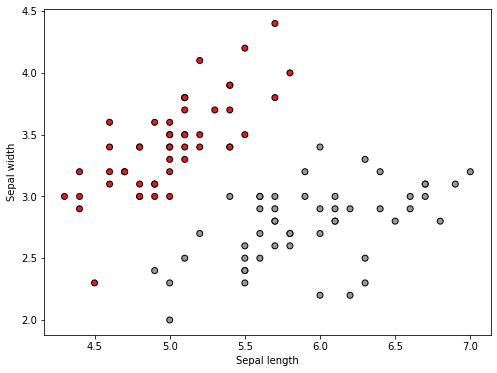

In [103]:
import matplotlib.pyplot as plt
plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [104]:
%%writefile predict_power_classifier.py

def predict_trouble(parameters = [0.8683269 , 0.39393166, 0.47681407, 0.30033276, 0.97830805, 0.52097628, 0.99194506, 0.92128744, 0.57695905, 0.36047569,0.83097868, 0.47035325], 
                    example):
    qc = QuantumCircuit(3)
    embed_example(qc, example)
    apply_parameters(qc, parameters)
    result = run_circuit(qc, Aer.get_backend("aer_simulator"))
    return make_prediction(result)
                        

def embed_example(circuit, example):
    circuit.rx(np.pi * example[0], 0)
    circuit.rx(np.pi * example[1], 1)
    circuit.rx(np.pi * example[2], 2)

def apply_parameters(circuit, parameters):
    # TODO: use full range
    layers = np.reshape(parameters, (int(len(parameters)/3), 3))
    layer_count = 1
    for layer in layers:
        for gate in range(len(layer)):
            if layer_count % 3 == 0:
                circuit.rx(np.pi * layer[gate], gate)
            elif layer_count % 3 == 1:
                circuit.ry(np.pi * layer[gate], gate)
            else:
                circuit.rz(np.pi * layer[gate], gate)
        circuit.cx(0,1)
        circuit.cx(1,2)
        circuit.cx(2,0)
        layer_count += 1
        circuit.barrier()
    circuit.measure_all()

def run_circuit(circuit, backend):

    num_shots = 500
    job = execute(circuit,
                  shots=num_shots,
                  backend=backend)

    # Return the measured counts
    return job.result().get_counts()

def make_prediction(result):
    count_0 = 0
    count_1 = 0
    for measurement in result:
        # Determine vote
        if measurement.count('1') > measurement.count('0'):
            count_1 += result[measurement]
        else:
            count0 += result[measurement]
    if count_1 > count_0:
        return 1
    else:
        return 0

Writing predict_power_classifier.py


In [6]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute

qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()
job = execute(qc, shots=1000, backend=Aer.get_backend("aer_simulator"))
# Return the measured counts
print(job.result().get_counts())

{'0': 498, '1': 502}
